In [2]:
#from plottable import Table
import pandas as pd
import matplotlib.pyplot as plt
from help_functions import collect_config_to_df, plot_common, plot_comparing_models, get_same_diff_df, show_plots, vizulaize_chunked, create_movie, plot_veff, plot_chunked_veff
import numpy as np



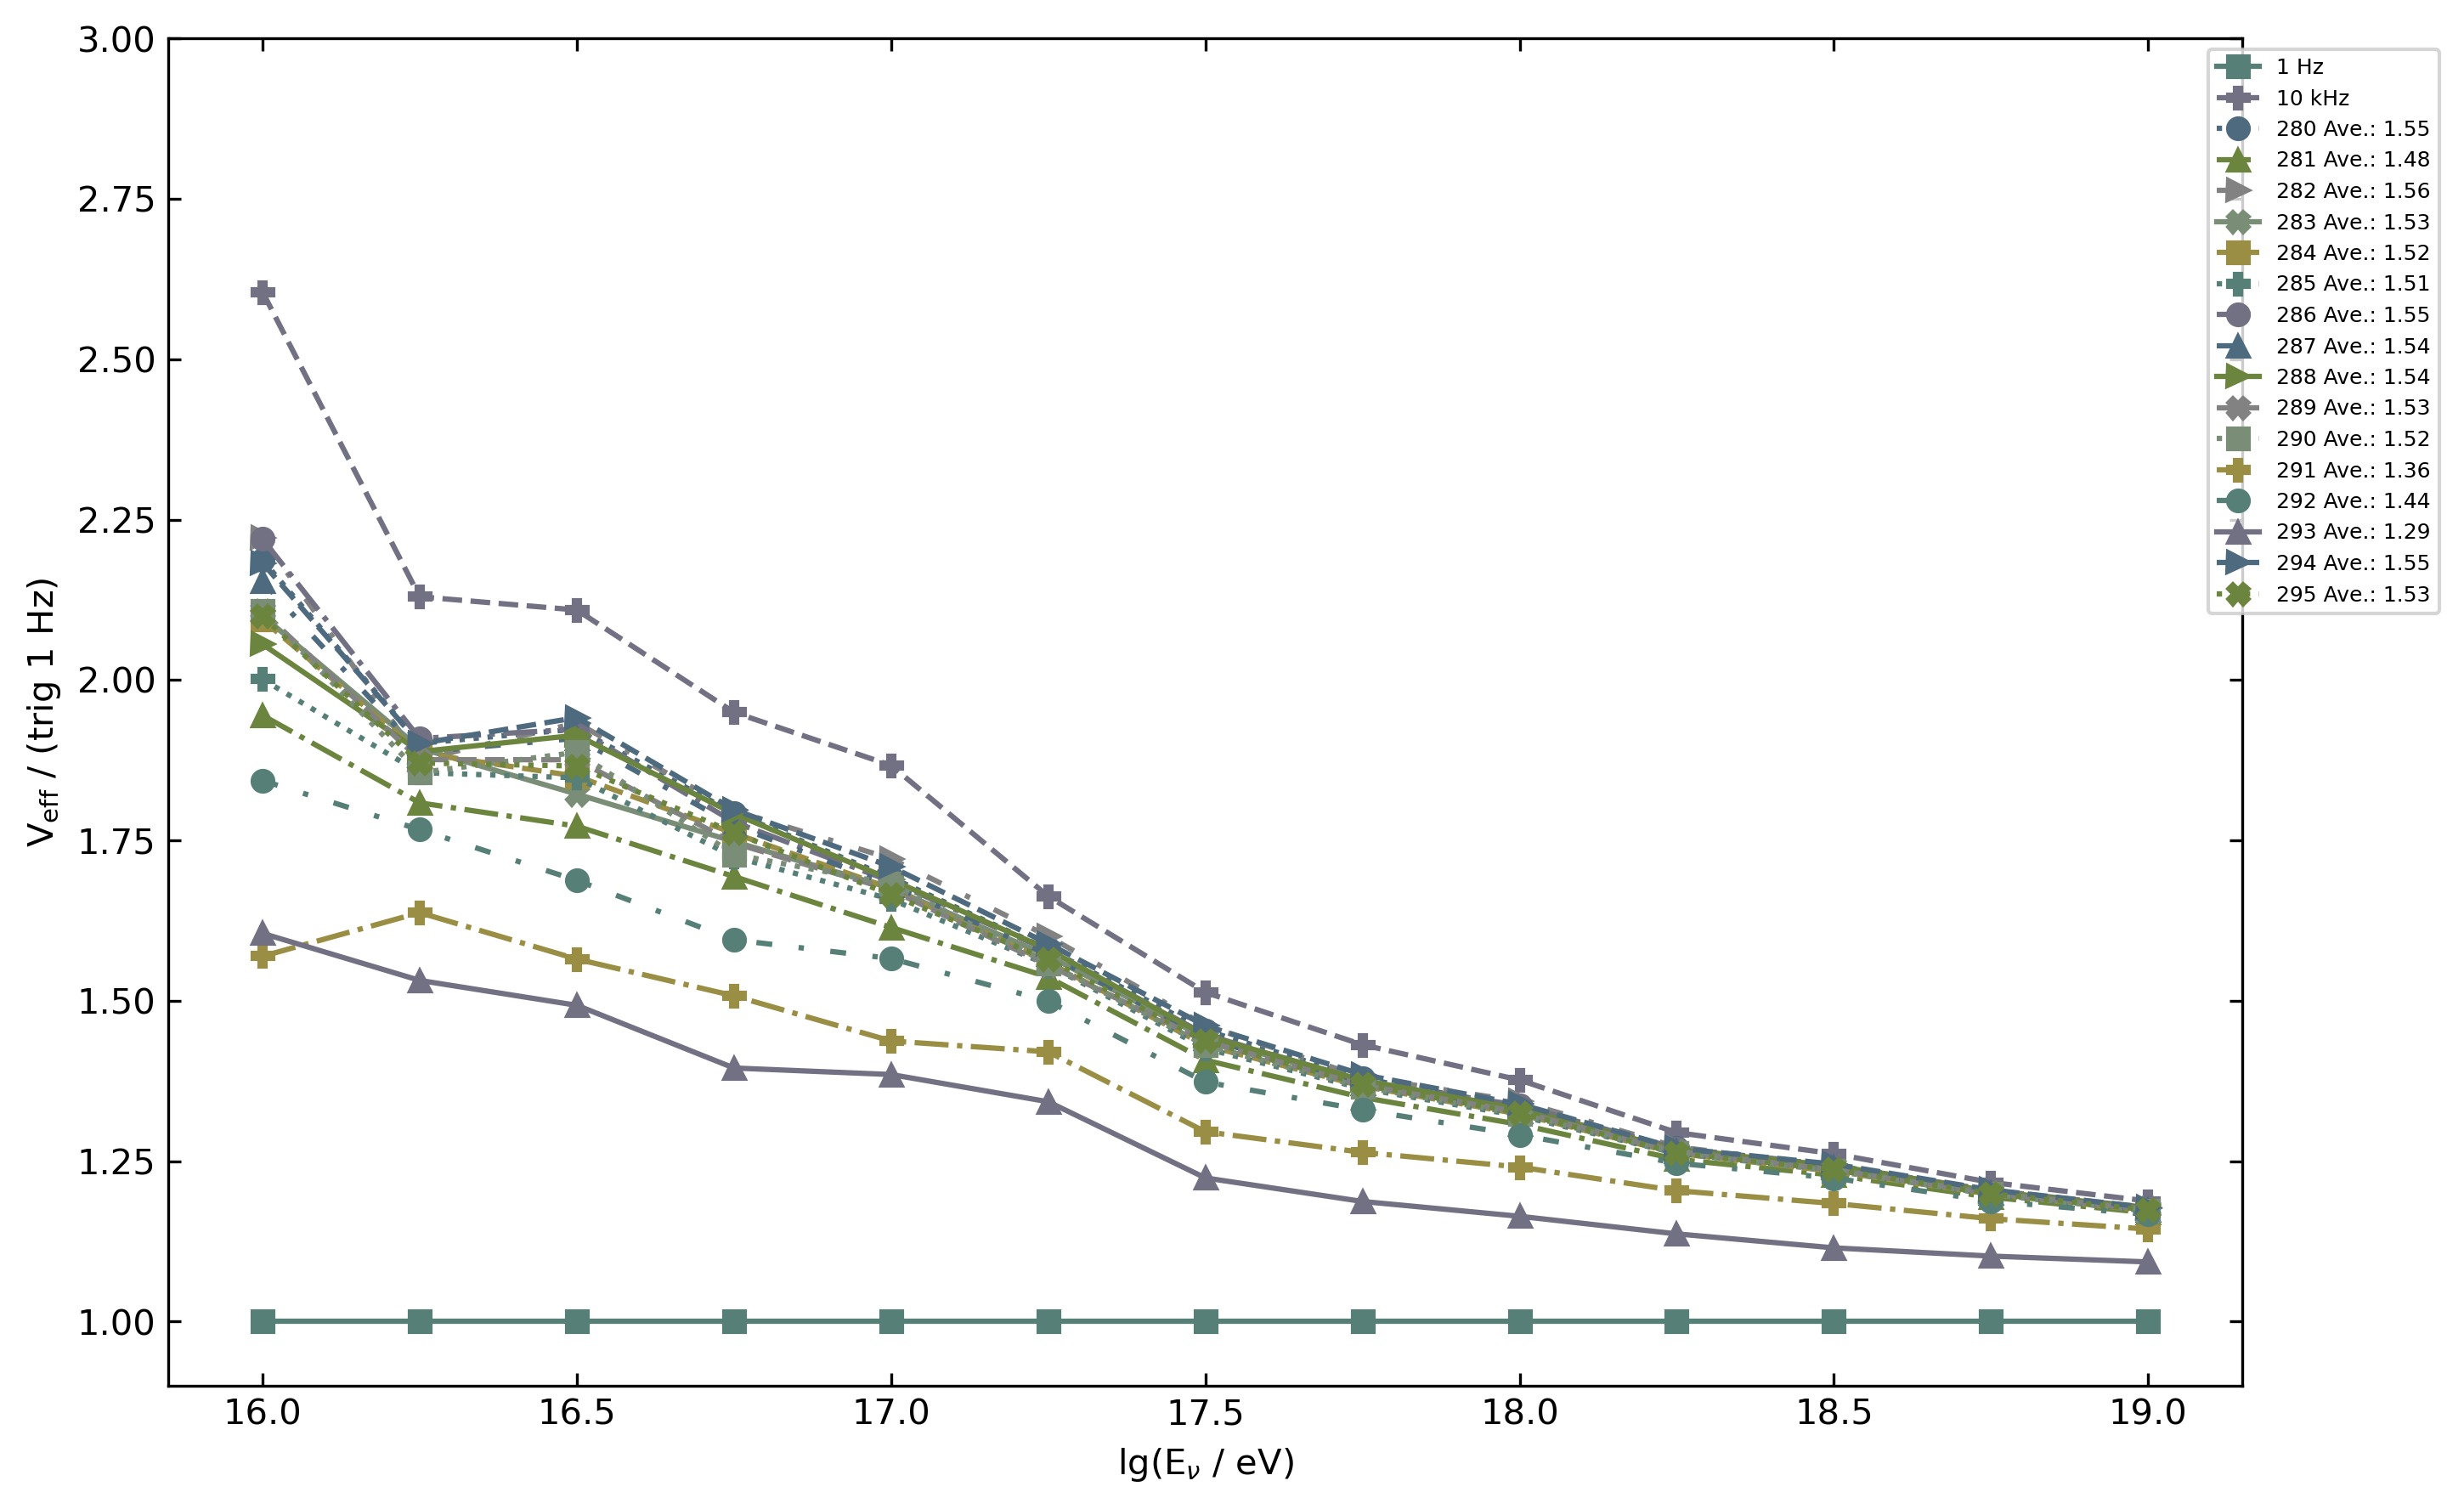

{'280': 1.5489647528124617, '281': 1.482871556897421, '282': 1.5560174805785487, '283': 1.5260866515201432, '284': 1.52408608076002, '285': 1.5091928745491632, '286': 1.5497376675666295, '287': 1.538060939919165, '288': 1.535442131600378, '289': 1.5261086419008667, '290': 1.5234406917708632, '291': 1.356021237434033, '292': 1.4442835936174343, '293': 1.290177922974951, '294': 1.5540288295498106, '295': 1.525479332263571}
[282 294 286 280 287 288 289 283 295 284 290 285 281 292 291 293]
[1.55601748 1.55402883 1.54973767 1.54896475 1.53806094 1.53544213
 1.52610864 1.52608665 1.52547933 1.52408608 1.52344069 1.50919287
 1.48287156 1.44428359 1.35602124 1.29017792]


In [3]:
models = list(range(280,296))
models = 
veff_files = []
for model in models:
    veff_files.append(f'/mnt/md0/halin/Models/model_{model}/plot/QuickVeffRatio_{model}_best.npz')

results = plot_veff(veff_files, plot_path='', y_max=3)
models = [int(key) for key in results.keys()]
values = list(results.values())
indices = np.argsort(-np.array(values))

# Use these indices to sort the models and values
models_sorted = np.array(models)[indices]
values_sorted = np.array(values)[indices]
print(models_sorted)
print(values_sorted)

Plot collections of noise reduction factors or roc curve

/software/anaconda3/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


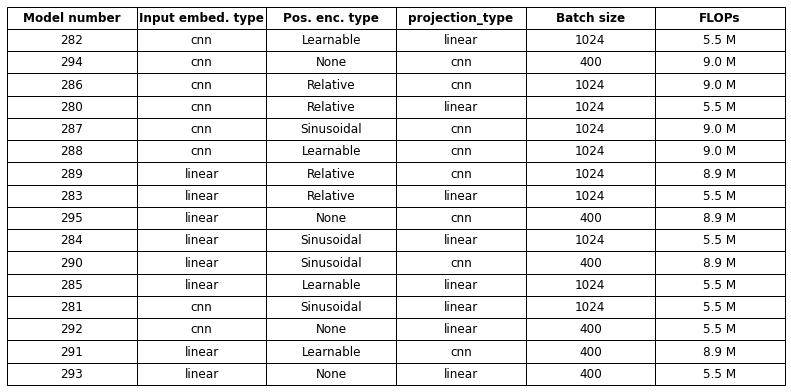

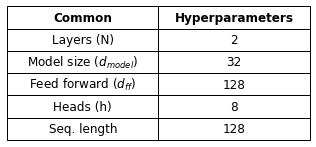

In [4]:
# model_path = '/home/hansalin/dl1/nuradio-analysis/configs/chunked/'
# models = [310,311,312,313,314,315]
model_path = '/mnt/md0/halin/Models/'
#models = list(range(250,274))
#models = [250,251]

df = collect_config_to_df(models, model_path=model_path, type_of_file='yaml')
col_width = 3.0
save = False
sort = False
prefix = ''
# compare_keys = ['model_num', 'N', 'num_param', 'NSE_AT_10KNRF','MACs']
# compare_df = df[compare_keys]
df_same, df_diff = get_same_diff_df(df)

exclude_columns = [
    # 'activation',
    # 'batch_size',
    # 'decreas_factor',
    # 'dropout',
    # #'embed_type',
    'NSE_AT_10KNRF',
    'encoder_param',
    'num_param',
    # 'encoder_type',
    'final_param',
    # #'final_type',
    'input_param',
    # 'learning_rate',
    # 'location',
    # 'loss_function',
    # #'max_relative_position',
    # 'n_ant',
    # 'normalization',
    # #'pos_enc_type',
    'pos_param',
    # 'residual_type',
    # 'seq_len',
    # 'step_size',
    # 'encode_type',
    'training_time',
    'MACs'

]
if df_diff.empty:
    print('No common values')
    plot_comparing_models(df_same.iloc[[0]], 
                          row_height=0.35, 
                          col_width=col_width, 
                          sort=False, 
                          exclude_columns=exclude_columns, 
                          save=save,
                          prefix=prefix
                          )
    exclude_columns = [
        'N',
        'MACs',
        'NSE_AT_10KNRF',
        'activation',
        'd_ff',
        'd_model',
        'embed_type',
        'encoder_param',
        'encoder_type',
        'final_param',
        'final_type',
        'h',
        'input_param',
        'location',
        
        'max_relative_position',
        'model_num',
        'n_ant',
        'normalization',
        'num_param',
        #'pos_enc_type',
        'pos_param',
        'residual_type',
        'encode_type',
        'training_time',
    ]
    plot_common(df_same.iloc[[0]] , 
                row_height=0.4, 
                col_width=col_width+0.5, 
                exclude_columns=exclude_columns, 
                save=save,
                prefix=prefix,
                )
else:
    plot_comparing_models(df_diff, 
                          row_height=0.35, 
                          col_width=col_width, 
                          sort=sort, 
                          exclude_columns=exclude_columns, 
                          save=save,
                          prefix=prefix,
                          )
    exclude_columns = [
    'activation',
    'batch_size',
    'decreas_factor',
    'dropout',
    'embed_type',
    'encoder_param',
    'encoder_type',
    'final_param',
    'final_type',
    'input_param',
    'num_param',
    'learning_rate',
    'location',
    'loss_function',
    'max_relative_position',
    'n_ant',
    'normalization',
    'pos_enc_type',
    'pos_param',
    'residual_type',
    # 'seq_len',
    'step_size',
    'encode_type',
    'training_time',
    'MACs',
    'NSE_AT_10KNRF',
    'max_pool',
    'FLOP',
    'step_size',
    'learning_rate',
    'projection_type',

]
    plot_common(df_same.iloc[[0]] , 
                row_height=0.4, 
                col_width=col_width + 0.5, 
                exclude_columns=exclude_columns, 
                save=save,
                prefix=prefix,
                )
# show_plots(model_num=200, search_string='roc')   